#About Dataset:
### **Why the CASIA2 Dataset is Important**  
The CASIA2 dataset is a key resource for detecting fake or manipulated images. It contains a mix of real and tampered images, including techniques like splicing, cloning, and copy-paste manipulation. These types of tampering share some common features with deepfake images, making CASIA2 valuable for training models to spot both traditional and modern forgeries. By using CASIA2, researchers can test and improve systems that help detect fake content, fight misinformation, and protect trust in digital media.

### **Using Stable Diffusion alongside the datset**  
We used the Stable Diffusion inpainting tool to create new, synthetic tampered images based on CASIA2 data. This added modern, AI-generated manipulations to the dataset, making it more relevant for detecting deepfakes. Training models on this updated dataset helps them identify not just older tampering methods but also newer, AI-driven fakes, making CASIA2 even more useful in addressing today’s challenges with fake content.

#1. Project Overview: "Image Tampering Classification with Synthetic Data Augmentation"
**Objective**: To classify images as authentic, real tampered, or synthetic tampered using a machine learning model with synthetic data augmentation.

**Scope**: Includes data preprocessing, synthetic data generation, model training, and fine-tuning. Focused on image tampering detection.

In [ ]:
pip install diffusers

In [1]:
from google.colab import drive
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from diffusers import StableDiffusionInpaintPipeline  # For synthetic data generation
import torch
from PIL import Image, ImageDraw
import pandas as pd

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

In [ ]:
# Step 1: Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import zipfile
import os

# Path to the ZIP file
zip_path = '/content/drive/MyDrive/CASIA2.zip'

# Destination directory
extract_dir = '/content/CASIA2'

# Unzipping the file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

print("Dataset extracted to:", extract_dir)


Dataset extracted to: /content/CASIA2


In [ ]:
authentic_path = '/content/CASIA2/Au'
tempered_path = '/content/CASIA2/Tp'

In [ ]:
synthetic_path = '/content/drive/MyDrive/datasets/CASIA2/Synthetic'

# Ensure synthetic directory exists
os.makedirs(synthetic_path, exist_ok=True)

In [ ]:
# Step 2: Load dataset with new class structure
def load_image_paths_and_labels(auth_path, temp_path, synthetic_path):
    authentic_images = [(os.path.join(auth_path, f), 0) for f in os.listdir(auth_path) if f.endswith('.jpg')]
    tampered_images = [(os.path.join(temp_path, f), 1) for f in os.listdir(temp_path) if f.endswith('.jpg')]
    synthetic_images = [(os.path.join(synthetic_path, f), 2) for f in os.listdir(synthetic_path) if f.endswith('.jpg')]
    print(f"Number of synthetic images found: {len(synthetic_images)}")  # Should print 300

    return pd.DataFrame(authentic_images + tampered_images + synthetic_images, columns=['path', 'label'])

metadata = load_image_paths_and_labels(authentic_path, tempered_path, synthetic_path)
metadata = metadata.sample(frac=1).reset_index(drop=True)  # Shuffle data
print(metadata['label'].value_counts())


Number of synthetic images found: 0
label
0    7437
1    2064
Name: count, dtype: int64


In [ ]:
# Step 3: Generate Synthetic Images
def generate_synthetic_images(input_images, output_path, num_images=100):
    """Generate synthetic tampered images using Stable Diffusion."""
    from diffusers import StableDiffusionInpaintPipeline
    import torch
    from PIL import Image, ImageDraw
    import os

    # Load the Stable Diffusion inpainting pipeline
    pipe = StableDiffusionInpaintPipeline.from_pretrained(
        "runwayml/stable-diffusion-inpainting", torch_dtype=torch.float16
    ).to("cuda")  # Use GPU for acceleration

    # Create synthetic images
    for i, img_path in enumerate(input_images[:num_images]):
        try:
            # Load and preprocess the image
            original_image = Image.open(img_path).convert("RGB").resize((512, 512))
            mask = Image.new("L", (512, 512), 0)
            ImageDraw.Draw(mask).rectangle([100, 100, 300, 300], fill=255)

            # Generate inpainted image
            inpainted_image = pipe(
                prompt="Create a synthetic tampered version",
                image=original_image,
                mask_image=mask
            ).images[0]

            # Save the synthetic image
            inpainted_image.save(os.path.join(output_path, f"synthetic_{i}.jpg"))
        except Exception as e:
            print(f"Error processing image {img_path}: {e}")

# Generate synthetic images from authentic images
synthetic_input_images = [os.path.join(authentic_path, f) for f in os.listdir(authentic_path) if f.endswith('.jpg')]
generate_synthetic_images(synthetic_input_images, synthetic_path, num_images=300)

# Step 4: Update metadata with synthetic images
def update_metadata_with_synthetic(metadata, synthetic_path):
    """Update metadata to include synthetic images."""
    synthetic_images = [(os.path.join(synthetic_path, f), 2) for f in os.listdir(synthetic_path) if f.endswith('.jpg')]
    synthetic_metadata = pd.DataFrame(synthetic_images, columns=['path', 'label'])
    metadata = pd.concat([metadata, synthetic_metadata], ignore_index=True)
    return metadata.sample(frac=1).reset_index(drop=True)  # Shuffle the data

metadata = update_metadata_with_synthetic(metadata, synthetic_path)

# Step 5: Balance the dataset
def balance_dataset(metadata, synthetic_class=2, max_synthetic_ratio=0.5):
    """Balance the dataset by limiting synthetic images."""
    max_synthetic = int(len(metadata[metadata['label'] == 1]) * max_synthetic_ratio)  # Proportional to real tampered
    synthetic_images = metadata[metadata['label'] == synthetic_class]

    # Limit the number of synthetic images
    if len(synthetic_images) > max_synthetic:
        synthetic_images = synthetic_images.sample(n=max_synthetic, random_state=42)

    # Combine authentic, real tampered, and limited synthetic tampered
    balanced_metadata = pd.concat(
        [metadata[metadata['label'] != synthetic_class], synthetic_images],
        ignore_index=True
    ).sample(frac=1).reset_index(drop=True)  # Shuffle data

    return balanced_metadata

metadata = balance_dataset(metadata)

# Debugging: Check the final class distribution
print(metadata['label'].value_counts())


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model_index.json:   0%|          | 0.00/548 [00:00<?, ?B/s]

Fetching 16 files:   0%|          | 0/16 [00:00<?, ?it/s]

safety_checker/config.json:   0%|          | 0.00/4.78k [00:00<?, ?B/s]

(…)ature_extractor/preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/748 [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/313 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/492M [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/617 [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/552 [00:00<?, ?B/s]

diffusion_pytorch_model.bin:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

diffusion_pytorch_model.bin:   0%|          | 0.00/335M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

An error occurred while trying to fetch /root/.cache/huggingface/hub/models--runwayml--stable-diffusion-inpainting/snapshots/8a4288a76071f7280aedbdb3253bdb9e9d5d84bb/unet: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--runwayml--stable-diffusion-inpainting/snapshots/8a4288a76071f7280aedbdb3253bdb9e9d5d84bb/unet.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
An error occurred while trying to fetch /root/.cache/huggingface/hub/models--runwayml--stable-diffusion-inpainting/snapshots/8a4288a76071f7280aedbdb3253bdb9e9d5d84bb/vae: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--runwayml--stable-diffusion-inpainting/snapshots/8a4288a76071f7280aedbdb3253bdb9e9d5d84bb/vae.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

label
0    7437
1    2064
2     300
Name: count, dtype: int64


In [ ]:
metadata['label'] = metadata['label'].astype(str)

train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=metadata,
    x_col='path',
    y_col='label',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',  # For 3 classes
    subset='training',
    shuffle=True
)

val_generator = train_datagen.flow_from_dataframe(
    dataframe=metadata,
    x_col='path',
    y_col='label',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',  # For 3 classes
    subset='validation',
    shuffle=True
)


Found 7841 validated image filenames belonging to 3 classes.
Found 1960 validated image filenames belonging to 3 classes.


In [ ]:
print(f"Training samples: {train_generator.samples}")
print(f"Validation samples: {val_generator.samples}")


Training samples: 7841
Validation samples: 1960


In [ ]:
print(train_generator.class_indices)
print(val_generator.class_indices)


{'0': 0, '1': 1, '2': 2}
{'0': 0, '1': 1, '2': 2}


In [ ]:
print("Training Class Distribution:", train_generator.class_indices)
print("Validation Class Distribution:", val_generator.class_indices)


Training Class Distribution: {'0': 0, '1': 1, '2': 2}
Validation Class Distribution: {'0': 0, '1': 1, '2': 2}


In [ ]:
# Step 5: Build model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(128, activation='relu')(x)
predictions = Dense(3, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
synthetic_in_train = sum(1 for label in train_generator.labels if label == 2)  # Iterate and count
synthetic_in_val = sum(1 for label in val_generator.labels if label == 2)    # Iterate and count
print(f"Synthetic in training: {synthetic_in_train}, Synthetic in validation: {synthetic_in_val}")

Synthetic in training: 236, Synthetic in validation: 64


In [ ]:
# Step 6: Train model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)
]

class_weights = {0: 1.0, 1: 3, 2: 10}
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,
    callbacks=callbacks,
    class_weight=class_weights
)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


246/246 ━━━━━━━━━━━━━━━━━━━━ 184s 678ms/step - accuracy: 0.5036 - loss: 1.9823 - val_accuracy: 0.3883 - val_loss: 0.8714 - learning_rate: 0.0010
Epoch 2/20
246/246 ━━━━━━━━━━━━━━━━━━━━ 170s 582ms/step - accuracy: 0.5641 - loss: 1.7818 - val_accuracy: 0.4485 - val_loss: 0.9190 - learning_rate: 0.0010
Epoch 3/20
246/246 ━━━━━━━━━━━━━━━━━━━━ 202s 584ms/step - accuracy: 0.6085 - loss: 1.7682 - val_accuracy: 0.7490 - val_loss: 0.8347 - learning_rate: 0.0010
Epoch 4/20
246/246 ━━━━━━━━━━━━━━━━━━━━ 146s 584ms/step - accuracy: 0.6797 - loss: 1.7309 - val_accuracy: 0.7515 - val_loss: 0.8276 - learning_rate: 0.0010
Epoch 5/20
246/246 ━━━━━━━━━━━━━━━━━━━━ 213s 628ms/step - accuracy: 0.6711 - loss: 1.7213 - val_accuracy: 0.7393 - val_loss: 0.9127 - learning_rate: 0.0010
Epoch 6/20
246/246 ━━━━━━━━━━━━━━━━━━━━ 143s 568ms/step - accuracy: 0.6978 - loss: 1.6978 - val_accuracy: 0.7510 - val_loss: 0.9217 - learning_rate: 0.0010
Epoch 7/20
246/246 ━━━━━━━━━━━━━━━━━━━━ 145s 573ms/step - accuracy: 0.7031 

In [ ]:
from sklearn.metrics import precision_recall_fscore_support


62/62 ━━━━━━━━━━━━━━━━━━━━ 34s 502ms/step
                    precision    recall  f1-score   support

         Authentic       0.76      0.99      0.86      1480
     Real Tampered       0.32      0.02      0.04       416
Synthetic Tampered       0.00      0.00      0.00        64

          accuracy                           0.75      1960
         macro avg       0.36      0.34      0.30      1960
      weighted avg       0.64      0.75      0.66      1960

Precision per class: [0.75710594 0.32       0.        ]
Recall per class: [0.98986486 0.01923077 0.        ]
F1-score per class: [0.8579795  0.03628118 0.        ]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/m

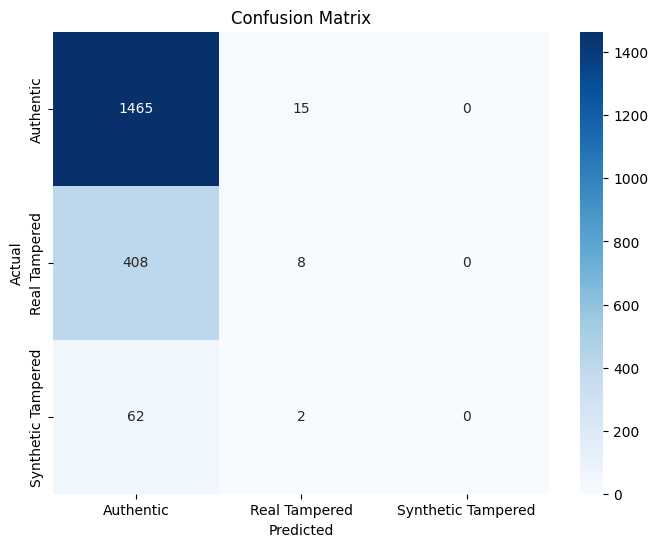

In [ ]:
# Step 7: Evaluate model
val_generator.reset()
preds = model.predict(val_generator, verbose=1)
y_true = val_generator.classes
y_pred = preds.argmax(axis=1)

print(classification_report(y_true, y_pred, target_names=['Authentic', 'Real Tampered', 'Synthetic Tampered']))
precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average=None)
print("Precision per class:", precision)
print("Recall per class:", recall)
print("F1-score per class:", f1)

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Authentic', 'Real Tampered', 'Synthetic Tampered'], yticklabels=['Authentic', 'Real Tampered', 'Synthetic Tampered'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
# Save the base model
original_model = tf.keras.models.clone_model(model)
original_model.set_weights(model.get_weights())


label
1    7437
0    7437
2    7437
Name: count, dtype: int64
Found 17849 validated image filenames belonging to 3 classes.
Found 4462 validated image filenames belonging to 3 classes.
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


558/558 ━━━━━━━━━━━━━━━━━━━━ 368s 630ms/step - accuracy: 0.3657 - loss: 1.2078 - val_accuracy: 0.4048 - val_loss: 1.0770 - learning_rate: 1.0000e-05
Epoch 2/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 358s 597ms/step - accuracy: 0.4178 - loss: 1.0681 - val_accuracy: 0.4189 - val_loss: 1.0607 - learning_rate: 1.0000e-05
Epoch 3/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 337s 600ms/step - accuracy: 0.4351 - loss: 1.0553 - val_accuracy: 0.4570 - val_loss: 1.0401 - learning_rate: 1.0000e-05
Epoch 4/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 337s 599ms/step - accuracy: 0.4603 - loss: 1.0353 - val_accuracy: 0.4348 - val_loss: 1.0618 - learning_rate: 1.0000e-05
Epoch 5/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 380s 593ms/step - accuracy: 0.4753 - loss: 1.0242 - val_accuracy: 0.4706 - val_loss: 1.0185 - learning_rate: 1.0000e-05
140/140 ━━━━━━━━━━━━━━━━━━━━ 72s 478ms/step
                    precision    recall  f1-score   support

         Authentic       0.37      0.09      0.15      1484
     Real Tampered       0.33      0.68      0

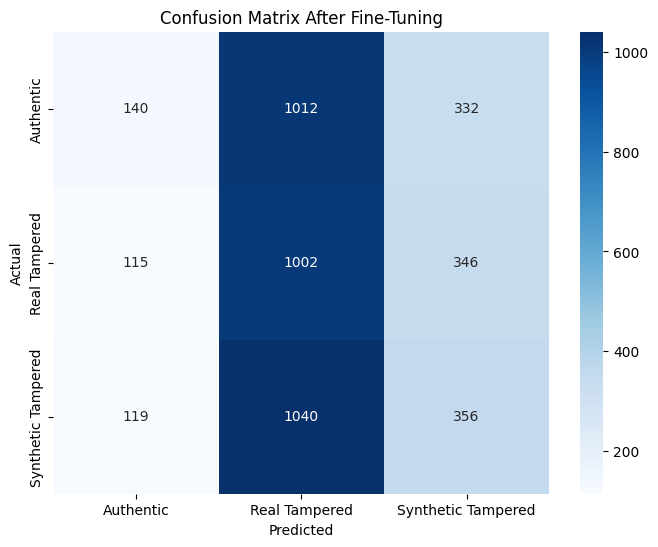

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils import resample

# Step 1: Handle Class Imbalance via Resampling
def resample_metadata(metadata, strategy="oversample"):
    classes = metadata['label'].unique()
    resampled_data = []

    max_class_size = metadata['label'].value_counts().max()
    min_class_size = metadata['label'].value_counts().min()

    for cls in classes:
        class_data = metadata[metadata['label'] == cls]
        if strategy == "oversample":
            resampled_class_data = resample(class_data, replace=True, n_samples=max_class_size, random_state=42)
        elif strategy == "downsample":
            resampled_class_data = resample(class_data, replace=False, n_samples=min_class_size, random_state=42)
        else:
            raise ValueError("Invalid strategy. Choose 'oversample' or 'downsample'.")
        resampled_data.append(resampled_class_data)

    return pd.concat(resampled_data).sample(frac=1).reset_index(drop=True)

# Oversample or Downsample
balanced_metadata = resample_metadata(metadata, strategy="oversample")  # Change to 'downsample' if needed
print(balanced_metadata['label'].value_counts())

# Step 2: Fine-Tune the Model
# Unfreeze top layers of the base model
for layer in base_model.layers[-10:]:  # Adjust the number of layers as needed
    layer.trainable = True

model.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

# Step 3: Create Data Generators with the Resampled Metadata
train_generator = train_datagen.flow_from_dataframe(
    dataframe=balanced_metadata,
    x_col='path',
    y_col='label',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

val_generator = train_datagen.flow_from_dataframe(
    dataframe=balanced_metadata,
    x_col='path',
    y_col='label',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation',
    shuffle=True
)

# Step 4: Fine-Tune the Model
fine_tune_history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    callbacks=callbacks,
    class_weight=None  # Class weights might not be needed due to resampling
)

# Step 5: Evaluate the Fine-Tuned Model
val_generator.reset()
fine_tune_preds = model.predict(val_generator, verbose=1)
fine_tune_y_pred = fine_tune_preds.argmax(axis=1)
fine_tune_y_true = val_generator.classes

print(classification_report(fine_tune_y_true, fine_tune_y_pred, target_names=['Authentic', 'Real Tampered', 'Synthetic Tampered']))

# Confusion Matrix
fine_tune_cm = confusion_matrix(fine_tune_y_true, fine_tune_y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(fine_tune_cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Authentic', 'Real Tampered', 'Synthetic Tampered'],
            yticklabels=['Authentic', 'Real Tampered', 'Synthetic Tampered'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix After Fine-Tuning')
plt.show()


### **Conclusion and Future Enhancements**  

The results highlight both the potential and challenges in leveraging the CASIA2 dataset, enhanced with synthetic tampered images, for detecting deepfakes. While the models achieved good accuracy in distinguishing authentic and tampered content, the detection of synthetic manipulations remains a challenge, particularly in identifying more subtle artifacts. This underscores the need for continued refinement in both dataset and model architecture.  

**Future enhancements** can focus on:
1. **Larger and Diverse Datasets**: Expanding the dataset with real-world examples and synthetic manipulations to improve generalization across unseen cases.  

2. **Improved Synthetic Image Generation**: Using more advanced prompts and methods in Stable Diffusion to create diverse, high-quality synthetic tampered images.  
3. **Fine-Tuning Model Architectures**: Exploring transformer-based architectures or hybrid models for improved feature extraction and classification.  

# Thank You ⚛ 😃